# pysb

## 9/14/2023

Many examples shamelessly stolen from [pysb.org](http://pysb.org/)

<a href="?print-pdf">print view</a><br>
<a href="bash.ipynb">notebook</a>

In [2]:
%%html
<script src="https://bits.csb.pitt.edu/preamble.js"></script>

## How do we model the output of a cell signaling network?

<img src="https://mscbio2025.github.io/notes/imgs/gpcr-mapk-g-protein.png">

# Cell Network Modeling

A system consists of various types of species (molecules and complexes) at different concentrations that may exist in a variety of states (e.g., bound, unbound, phosphorylated, nuclear localized, etc). Reactions govern how species concentrations and states vary over time.

These reactions are commonly represented as networks of ordinary differential equations (mass action kinetics).

*In chemistry, the law of mass action is a mathematical model that explains and predicts behaviours of solutions in dynamic equilibrium. Simply put, it states that the rate of a chemical reaction is proportional to the product of the masses of the reactants. Necessarily, this implies that for a chemical reaction mixture that is in equilibrium, the ratio between the concentration of reactants and products is constant.*
-- Wikipedia

# Example: Ligand Binding

Consider a ligand, L, and receptor, R, that bind:

$$L + R \rightleftharpoons LR$$

This reaction has a forward rate constant, $k_f$ and a reverse rate constant $k_r$.

($k_{\mathrm{on}}$ and $k_{\mathrm{off}}$ are an alternative nomenclature)

forward reaction rate $(\frac{M}{s})$ = $k_f[L][R]$

reverse reaction rate $(\frac{M}{s})$ = $k_r[LR]$

In [3]:
%%html
<div id="sbk" style="width: 500px"></div>
<script>
$('head').append('<link rel="stylesheet" href="https://bits.csb.pitt.edu/asker.js/themes/asker.default.css" />');

    var divid = '#sbk';
	jQuery(divid).asker({ 
	    id: divid,
	    question: "What are the units of k<sub>r</sub>?",
		answers: ['s<sup>−1</sup>','M<sup>−1</sup>s<sup>−1</sup>','M<sup>−2</sup>s<sup>−1</sup>','M<sup>−2</sup>'],
        server: "https://bits.csb.pitt.edu/asker.js/example/asker.cgi",
		charter: chartmaker})
    
$(".jp-InputArea .o:contains(html)").closest('.jp-InputArea').hide();

</script>

# Example: Ligand Binding

The rate of change of the various concentration can be represented with these equations:

$$\frac{\partial [L]}{\partial t} = -k_f  [L] [R] + k_r [LR]$$

$$\frac{\partial [R]}{\partial t} = -k_f  [L] [R] + k_r [LR]$$

$$\frac{\partial [LR]}{\partial t} = k_f  [L] [R] - k_r [LR]$$

We can use [`scipy.integrate`](http://docs.scipy.org/doc/scipy/reference/integrate.html) to solve these ODEs for a given set of initial conditions.


But that is a little painful even for this example, and really painful for a complex system with many interacting molecular species.

# Rule Based Modeling

Rule-based modeling provides an alternative to creating massive sets of equations.

Instead, you create a less massive set of rules that are at a more appropriate level of abstraction.  For example, here is the [BioNetGen](http://bionetgen.org) rule equivalent for ligand binding:

    begin reaction rules
        L(r) + R(l) <-> L(r!1).R(l!1) kf, kr
    end reaction rules

`L` and `R` are the molecules which each have a single component (`l` and `r`).  They participate in a reversible reaction (`<->`) to form a complex (`.`) where `l` and `r` bind (indicated by `!1`).  The reaction has constants `kf` and `kr`.

# PySB: Rule Based Modeling in Python

PySB enables you to specify rule-based models are specified natively in python. Your model is a python module.

The use of native python code to specify modules allows for modularity, function decomposition, and code reuse (e.g., can write a function to define a certain common model motif).

By convention, model definition is in a separate file from the code that uses the model (but this isn't what we're doing in the assignment).

Fun fact: PySB uses BioNetGen under the hood, so any model you specify in PySB can also be exported as a BioNetGen model.

# PySB Self-Exporting

PySB *self-exports* variables when you call its function.  This is slightly strange (from a software engineering standpoint) but results in a clearer syntax.

To create a model:

In [4]:
from pysb import *  #importing everything
Model()

<Model '_interactive_' (monomers: 0, rules: 0, parameters: 0, expressions: 0, compartments: 0) at 0x7fbeabe61600>

**This automatically creates (self-exports) a variable called `model`**

In [5]:
model

<Model '_interactive_' (monomers: 0, rules: 0, parameters: 0, expressions: 0, compartments: 0) at 0x7fbeabe61600>

# Monomers

"Monomers are the indivisible elements that will make up the molecules and complexes whose behavior you intend to model."

`Monomer(`*name*, *sites*, *states*`)`
 * *name* The name of the monomer. A variable with this name will be created to represent this monomer
 * *sites* List of named locations on the monomer. Necessary for binding and for representing different states.
 * *states* Optional. A dictionary mapping sites to a list of possible states (e.g. inactive/active).

In [6]:
Monomer('L', ['s'])
Monomer('R', ['s'])
print(L,R) #self-exported

Monomer('L', ['s']) Monomer('R', ['s'])


# Parameters

Parameters are named numerical constants that can be used as initial concentrations or reaction rates.

In [7]:
Parameter('L_0', 100)
Parameter('R_0', 200)
Parameter('kf', 1e-3)
Parameter('kr', 1e-3)

Parameter('kr', 0.001)

Names are exported:

In [8]:
print(L_0,L_0.value)

Parameter('L_0', 100.0) 100.0


# Rules

Rules are created by specifying a name for the rule (which becomes the name of the corresponding variable), a RuleExpression, and one or two reaction constants.  

The syntax for RuleExpressions is very similar to BioNetGen (in fact, PySB uses BioNetGen under the hood).

In [9]:
Rule('L_binds_R', L(s=None) + R(s=None) | L(s=1) % R(s=1), kf, kr)

Rule('L_binds_R', L(s=None) + R(s=None) | L(s=1) % R(s=1), kf, kr)

In [10]:
print(L_binds_R)

Rule('L_binds_R', L(s=None) + R(s=None) | L(s=1) % R(s=1), kf, kr)


# RuleExpressions

 * **+** operator to represent complexation (addition)
 * **|** operator to represent backward/forward reaction (in Python2 this was <>)
 * **>>** operator to represent forward-only reaction
 * **%** operator to represent a binding interaction between two species
 
 The state of the sites must be specified (can be `None`). To indicate that two sites are bound in a binding interaction assign them the same number.

In [11]:
# Rule('L_binds_R', L(s=None) + R(s=None) | L(s=1) % R(s=1), kf, kr)
print(L_binds_R)

Rule('L_binds_R', L(s=None) + R(s=None) | L(s=1) % R(s=1), kf, kr)


# Initial Conditions

In order to integrate the ODEs underlying the model, we need to specify any non-zero initial conditions.

These need to be set with a Parameter object (not a numerical value).

In [12]:
Initial(L(s=None), L_0)  # L_0 is a parameter
Initial(R(s=None), R_0)  # R_0 is a parameter

Initial(R(s=None), R_0)

# Observables

Finally, we specify what species and/or combinations of species we want to monitor the concentrations of by creating `Observable` objects.  These take a name and an expression to observe.

In [13]:
Observable('unboundL', L(s=None))
Observable('unboundR', R(s=None))
Observable('LR', L(s=1) % R(s=1))

Observable('LR', L(s=1) % R(s=1))

# The Model

All of these expressions automatically add themselves to the current model object.

In [14]:
model

<Model '_interactive_' (monomers: 2, rules: 1, parameters: 4, expressions: 0, compartments: 0) at 0x7fbeabe61600>

In [15]:
model.parameters

ComponentSet([
 Parameter('L_0', 100.0),
 Parameter('R_0', 200.0),
 Parameter('kf', 0.001),
 Parameter('kr', 0.001),
 ])

In [16]:
from pysb import *

Model()

Monomer('L', ['s'])
Monomer('R', ['s'])

Parameter('L_0', 100)
Parameter('R_0', 200)
Parameter('kf', 1e-3)
Parameter('kr', 1e-3)

Initial(L(s=None), L_0)
Initial(R(s=None), R_0)

Rule('L_binds_R', L(s=None) + R(s=None) | L(s=1) % R(s=1), kf, kr)

Observable('unboundL', L(s=None))
Observable('unboundR', R(s=None))
Observable('LR', L(s=1) % R(s=1))

/tmp/ipykernel_934004/2677022237.py:3: ModelExistsWarning: Redefining model! (You can probably ignore this if you are running code interactively)
  Model()


Observable('LR', L(s=1) % R(s=1))

# Seeing the Model

PySB comes with a script for creating a GraphViz `.dot` file.

`python -m pysb.tools.render_reactions lrmodel.py  > lrmodel.dot`

`dot -Tpng lrmodel.dot > lrmodel.png`

<img src="https://mscbio2025.net/notes/imgs/hello.png">

# Using the Model

For a given time span we can solve the ODEs to track changes in concentration.

In [17]:
from pysb.integrate import odesolve
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

time = np.linspace(0, 40, 100)
sol = odesolve(model, time)

In [18]:
np.linspace(start=0,stop=20,num=5)  #generates num evenly spaced points from start to stop

array([ 0.,  5., 10., 15., 20.])

The returned value from `odesolve` can be indexed by the observables.

In [19]:
sol['LR']

array([ 0.        ,  7.61654594, 14.40182471, 20.47986002, 25.95122824,
       30.89839963, 35.38952808, 39.4815096 , 43.22220517, 46.65213929,
       49.80587027, 52.71305357, 55.39926949, 57.88670512, 60.19471768,
       62.34026906, 64.3382599 , 66.20183836, 67.94266504, 69.57112061,
       71.09646951, 72.52700243, 73.87016406, 75.13266138, 76.32055215,
       77.43931976, 78.49393939, 79.48893343, 80.42842847, 81.31619634,
       82.15568519, 82.95006828, 83.70225069, 84.41490605, 85.09050052,
       85.7313101 , 86.33943955, 86.91684046, 87.46532227, 87.98656395,
       88.48212763, 88.95346687, 89.40193616, 89.82879984, 90.23523942,
       90.62235912, 90.99119274, 91.34270913, 91.67781634, 91.99736673,
       92.30216148, 92.59295349, 92.87045117, 93.13532197, 93.38819448,
       93.62966147, 93.86028251, 94.08058578, 94.2910703 , 94.49220775,
       94.68444428, 94.86820255, 95.04388179, 95.2118625 , 95.37250242,
       95.52614429, 95.67310975, 95.81370667, 95.94822593, 96.07

In [20]:
%%html
<div id="sollen" style="width: 500px"></div>
<script>

    var divid = '#sollen';
	jQuery(divid).asker({
	    id: divid,
	    question: "What is the length of this array?",
		answers: ['39','40','99','100'],
        server: "https://bits.csb.pitt.edu/asker.js/example/asker.cgi",
		charter: chartmaker})
    
$(".jp-InputArea .o:contains(html)").closest('.jp-InputArea').hide();


</script>

# Plotting

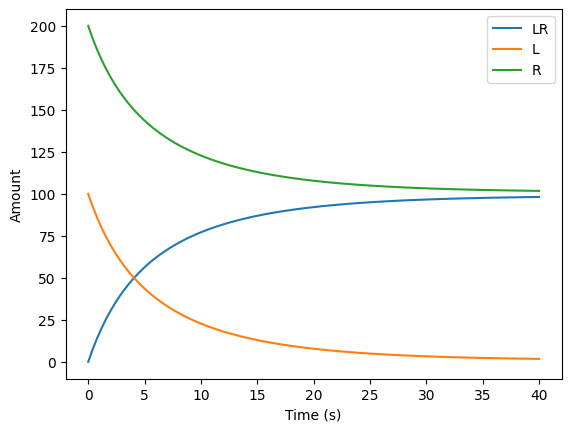

In [21]:
plt.plot(time,sol['LR'], label='LR')
plt.plot(time,sol['unboundL'], label='L')
plt.plot(time,sol['unboundR'], label='R')
plt.xlabel("Time (s)")
plt.ylabel("Amount")
plt.legend()
plt.show()

# Modifying Parameters

The model object is *mutable* - we can easily change parameters and see what happens.

In [22]:
model.parameters['kf'].value = 0.0001
time = np.linspace(0, 200, 100)
sol = odesolve(model, time)

In [23]:
%%html
<div id="rateintuit" style="width: 500px"></div>
<script>

    var divid = '#rateintuit';
	jQuery(divid).asker({
	    id: divid,
	    question: "How will the concentration of LR change at time 40 compared to kf = 0.001?",
		answers: ['Less','Same','More','Error'],
        server: "https://bits.csb.pitt.edu/asker.js/example/asker.cgi",
		charter: chartmaker})
    
$(".jp-InputArea .o:contains(html)").closest('.jp-InputArea').hide();


</script>

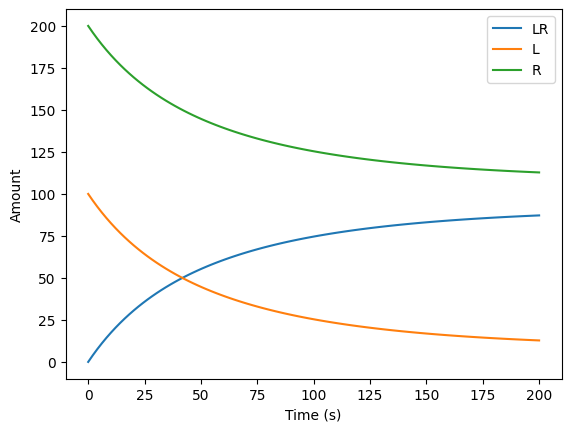

In [24]:
plt.plot(time,sol['LR'], label='LR')
plt.plot(time,sol['unboundL'], label='L')
plt.plot(time,sol['unboundR'], label='R')
plt.xlabel("Time (s)"); plt.ylabel("Amount"); plt.legend(); plt.show()

# Macros

The real advantage of PySB is the ability to create reusable macros of common rule patterns.

* `equilibrate` -  Generate the reversible equilibrium reaction S1 <-> S2
* `bind` - Generate the reversible binding reaction S1 + S2 | S1:S2 
* `catalyze` - Generate the two-step catalytic reaction E + S | E:S >> E + P
* `catalyze_one_step` - Generate the one-step catalytic reaction E + S >> E + P
* `catalyze_one_step_reversible` -     Create fwd and reverse rules for catalysis of the form: E + S -> E + P, P -> S
* `synthesize` - Generate a reaction which synthesizes a species
* `degrade` - Generate a reaction which degrades a species
* `assemble_pore_sequential` - Generate rules to assemble a circular homomeric pore sequentially
* `pore_transport` - Generate rules to transport cargo through a circular homomeric pore

In [25]:
from pysb.macros import *
help(catalyze_state)

Help on function catalyze_state in module pysb.macros:

catalyze_state(enzyme, e_site, substrate, s_site, mod_site, state1, state2, klist)
    Generate the two-step catalytic reaction E + S | E:S >> E + P. A wrapper
    around catalyze() with a signature specifying the state change of the
    substrate resulting from catalysis.
    
    Parameters
    ----------
    enzyme : Monomer or MonomerPattern
        E in the above reaction.
    substrate : Monomer or MonomerPattern
        S and P in the above reaction. The product species is assumed to be
        identical to the substrate species in all respects except the state
        of the modification site. The state of the modification site should
        not be specified in the MonomerPattern for the substrate.
    e_site, s_site : string
        The names of the sites on `enzyme` and `substrate` (respectively) where
        they bind each other to form the E:S complex.
    mod_site : string
        The name of the site on the substra

# Example: Kinase Cascade

<img src="https://mscbio2025.github.io/notes/imgs/chen_mapk_diagram.png">

[Source](https://www.embopress.org/doi/full/10.1038/msb.2008.74)

[https://github.com/pysb/pysb/blob/master/pysb/examples/kinase_cascade.py](https://github.com/pysb/pysb/blob/master/pysb/examples/kinase_cascade.py)

In [26]:
Model()

Monomer('Ras', ['k'])
Monomer('Raf', ['s', 'k'], {'s': ['u', 'p']})
Monomer('MEK', ['s218', 's222', 'k'], {'s218': ['u', 'p'], 's222': ['u', 'p']})
Monomer('ERK', ['t185', 'y187'], {'t185': ['u', 'p'], 'y187': ['u', 'p']})
Monomer('PP2A', ['ppt']) #phosphatase
Monomer('MKP', ['ppt']) ##phosphatase


Monomer('MKP', ['ppt'])

In [27]:
%%html
<div id="sbsite" style="width: 500px"></div>
<script>

    var divid = '#sbsite';
	jQuery(divid).asker({
	    id: divid,
	    question: "What is the 'k' in <tt>Monomer('Ras', ['k'])</tt>?",
		answers: ['An okay state, K?','A binding site for GTP','A phosphorylation site','A binding site for Raf','An active state'],
        server: "https://bits.csb.pitt.edu/asker.js/example/asker.cgi",
		charter: chartmaker})
    
$(".jp-InputArea .o:contains(html)").closest('.jp-InputArea').hide();


</script>

In [28]:
# Use generic rates for forward/reverse binding and kinase/phosphatase catalysis
kf_bind = 1e-5
kr_bind = 1e-1
kcat_phos = 1e-1
kcat_dephos = 3e-3

# Build handy rate "sets"
klist_bind = [kf_bind, kr_bind]
klist_phos = klist_bind + [kcat_phos]
klist_dephos = klist_bind + [kcat_dephos]

In [29]:
from pysb.macros import catalyze_state

def mapk_single(kinase, pptase, substrate, site):
    """Kinase phos/dephosphorylation."""
    ppt_substrate = substrate()
    if 'k' in ppt_substrate.monomer.sites:
        # Ensure substrates which are themselves kinases don't get
        # dephosphorylated while they are bound to *their* substrate.
        ppt_substrate = ppt_substrate(k=None)
    components = catalyze_state(kinase, 'k',
                                substrate, site, site, 'u', 'p',
                                klist_phos)
    components |= catalyze_state(pptase, 'ppt',
                                 ppt_substrate, site, site, 'p', 'u',
                                 klist_dephos)
    return components

In [30]:
def mapk_double(kinase, pptase, substrate, site1, site2):
    """Distributive + ordered double kinase phos/dephosphorylation."""
    components = mapk_single(kinase, pptase, substrate({site2: 'u'}), site1) # site2 must be unphos. for site1 to get phos.
    components |= mapk_single(kinase, pptase, substrate({site1: 'p'}), site2) # site1 must be phos. for site2 to get phos.
    return components

In [31]:
    # Ras-Raf-MEK-ERK kinase cascade
mapk_single(Ras, PP2A, Raf, 's')
mapk_double(Raf(s='p'), PP2A, MEK, 's218', 's222')
mapk_double(MEK(s218='p', s222='p'), MKP, ERK, 't185', 'y187')

ComponentSet([
 Rule('bind_MEKpp_ERKuu_to_MEKppERKu', MEK(s218='p', s222='p', k=None) + ERK(t185='u', y187='u') | MEK(s218='p', s222='p', k=1) % ERK(t185=('u', 1), y187='u'), bind_MEKpp_ERKuu_to_MEKppERKu_kf, bind_MEKpp_ERKuu_to_MEKppERKu_kr),
 Parameter('bind_MEKpp_ERKuu_to_MEKppERKu_kf', 1e-05),
 Parameter('bind_MEKpp_ERKuu_to_MEKppERKu_kr', 0.1),
 Rule('catalyze_MEKppERKu_to_MEKpp_ERKup', MEK(s218='p', s222='p', k=1) % ERK(t185=('u', 1), y187='u') >> MEK(s218='p', s222='p', k=None) + ERK(t185='p', y187='u'), catalyze_MEKppERKu_to_MEKpp_ERKup_kc),
 Parameter('catalyze_MEKppERKu_to_MEKpp_ERKup_kc', 0.1),
 Rule('bind_MKP_ERKup_to_MKPERKu', MKP(ppt=None) + ERK(t185='p', y187='u') | MKP(ppt=1) % ERK(t185=('p', 1), y187='u'), bind_MKP_ERKup_to_MKPERKu_kf, bind_MKP_ERKup_to_MKPERKu_kr),
 Parameter('bind_MKP_ERKup_to_MKPERKu_kf', 1e-05),
 Parameter('bind_MKP_ERKup_to_MKPERKu_kr', 0.1),
 Rule('catalyze_MKPERKu_to_MKP_ERKuu', MKP(ppt=1) % ERK(t185=('p', 1), y187='u') >> MKP(ppt=None) + ERK(t1

In [32]:
Initial(Ras(k=None), Parameter('Ras_0', 6e4))
Initial(Raf(s='u', k=None), Parameter('Raf_0', 7e4))
Initial(MEK(s218='u', s222='u', k=None), Parameter('MEK_0', 3e6))
Initial(ERK(t185='u', y187='u'), Parameter('ERK_0', 7e5))
Initial(PP2A(ppt=None), Parameter('PP2A_0', 2e5))
Initial(MKP(ppt=None), Parameter('MKP_0', 1.7e4))

Observable('ppMEK', MEK(s218='p', s222='p'))
Observable('ppERK', ERK(t185='p', y187='p'))

Observable('ppERK', ERK(t185='p', y187='p'))

In [33]:
time = np.linspace(0, 500, 100)
x = odesolve(model, time)

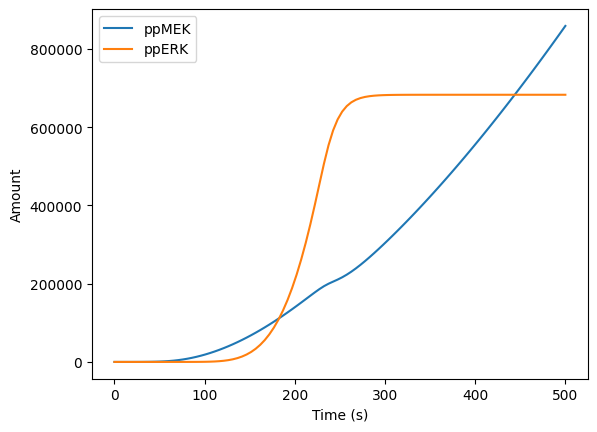

In [34]:
plt.plot(time,x['ppMEK'], label='ppMEK')
plt.plot(time,x['ppERK'], label='ppERK')
plt.xlabel("Time (s)")
plt.ylabel("Amount")
plt.legend(loc='best')
plt.show()

https://www.pnas.org/content/93/19/10078.short

# Project

 * Modify the model to print out all the phosphorylation states of ERK.
 * Inhibitors have been developed for every kinase in this cascade.  For simplicity, let's model the effect of an inhibitor for a specific kinase by decreasing its catalytic rate by a factor of 10. Plot the amount of ppERK for different catalytic rates for RAS, RAF, and MEK.

In [35]:
from pysb import *
from pysb.macros import catalyze_state

Model()

Monomer('Ras', ['k'])
Monomer('Raf', ['s', 'k'], {'s': ['u', 'p']})
Monomer('MEK', ['s218', 's222', 'k'], {'s218': ['u', 'p'], 's222': ['u', 'p']})
Monomer('ERK', ['t185', 'y187'], {'t185': ['u', 'p'], 'y187': ['u', 'p']})
Monomer('PP2A', ['ppt']) #phosphatase
Monomer('MKP', ['ppt']) ##phosphatase

# Use generic rates for forward/reverse binding and kinase/phosphatase catalysis
kf_bind = 1e-5
kr_bind = 1e-1
kcat_phos = 1e-1
kcat_dephos = 3e-3

# Build handy rate "sets"
klist_bind = [kf_bind, kr_bind]
klist_phos = klist_bind + [kcat_phos]
klist_dephos = klist_bind + [kcat_dephos]


def mapk_single(kinase, pptase, substrate, site):
    """Kinase phos/dephosphorylation."""
    ppt_substrate = substrate()
    if 'k' in ppt_substrate.monomer.sites:
        # Ensure substrates which are themselves kinases don't get
        # dephosphorylated while they are bound to *their* substrate.
        ppt_substrate = ppt_substrate(k=None)
    components = catalyze_state(kinase, 'k',
                                substrate, site, site, 'u', 'p',
                                klist_phos)
    components |= catalyze_state(pptase, 'ppt',
                                 ppt_substrate, site, site, 'p', 'u',
                                 klist_dephos)
    return components

def mapk_double(kinase, pptase, substrate, site1, site2):
    """Distributive + ordered double kinase phos/dephosphorylation."""
    components = mapk_single(kinase, pptase, substrate({site2: 'u'}), site1)
    components |= mapk_single(kinase, pptase, substrate({site1: 'p'}), site2)
    return components

# Ras-Raf-MEK-ERK kinase cascade
mapk_single(Ras, PP2A, Raf, 's')
mapk_double(Raf(s='p'), PP2A, MEK, 's218', 's222')
mapk_double(MEK(s218='p', s222='p'), MKP, ERK, 't185', 'y187')

Initial(Ras(k=None), Parameter('Ras_0', 6e4))
Initial(Raf(s='u', k=None), Parameter('Raf_0', 7e4))
Initial(MEK(s218='u', s222='u', k=None), Parameter('MEK_0', 3e6))
Initial(ERK(t185='u', y187='u'), Parameter('ERK_0', 7e5))
Initial(PP2A(ppt=None), Parameter('PP2A_0', 2e5))
Initial(MKP(ppt=None), Parameter('MKP_0', 1.7e4))

Observable('ppMEK', MEK(s218='p', s222='p'))
Observable('ppERK', ERK(t185='p', y187='p'))

Observable('ppERK', ERK(t185='p', y187='p'))

In [36]:
Observable('p1ERK', ERK(t185='p', y187='u'))
Observable('p2ERK', ERK(t185='u', y187='p'))
Observable('uERK', ERK(t185='u', y187='u'))

Observable('uERK', ERK(t185='u', y187='u'))

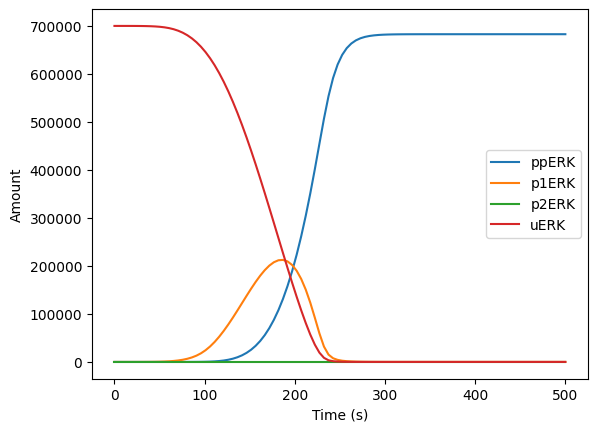

In [37]:
time = np.linspace(0, 500, 100)
x = odesolve(model, time)
plt.plot(time,x['ppERK'], label='ppERK')
plt.plot(time,x['p1ERK'], label='p1ERK')
plt.plot(time,x['p2ERK'], label='p2ERK')
plt.plot(time,x['uERK'], label='uERK')
plt.xlabel("Time (s)")
plt.ylabel("Amount")
plt.legend(loc='best')
plt.show()

In [38]:
model.parameters['catalyze_RasRaf_to_Ras_Rafp_kc'].value = 0.01
x2 = odesolve(model, time)

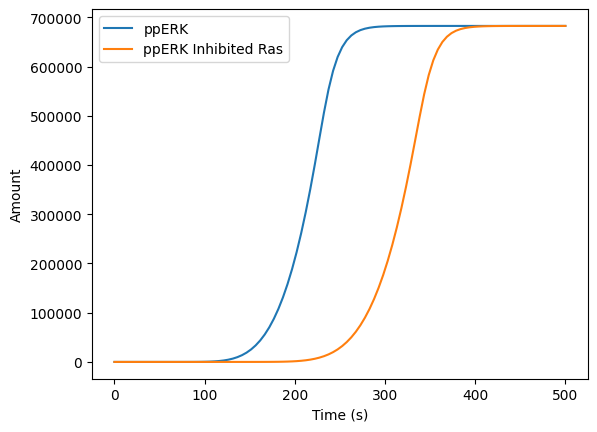

In [39]:
plt.plot(time,x['ppERK'], label='ppERK')
plt.plot(time,x2['ppERK'], label='ppERK Inhibited Ras')

plt.xlabel("Time (s)")
plt.ylabel("Amount")
plt.legend(loc='best')
plt.show()

# Assignment 3

Get started.  Complete each step in order.

# Rubber Duck Debugging

<img src="imgs/duck.jpeg" style="float:right">

*In software engineering, rubber duck debugging is a method of debugging code. The name is a reference to a story in the book The Pragmatic Programmer in which a programmer would carry around a rubber duck and debug their code by forcing themselves to explain it, line-by-line, to the duck.  In describing what the code is supposed to do and observing what it actually does, any incongruity between these two becomes apparent.*

--Wikipedia

# Rubber Duck Debugging

The rubber duck debugging method is as follows:

1. Beg, borrow, steal, buy, fabricate or otherwise obtain a rubber duck (bathtub variety).
2. Place rubber duck on desk and inform it you are just going to go over some code with it, if that’s all right.
3. Explain to the duck what your code is supposed to do, and then go into detail and explain your code line by line.
4. At some point you will tell the duck what you are doing next and then realise that that is not in fact what you are actually doing. The duck will sit there serenely, happy in the knowledge that it has helped you on your way.

https://rubberduckdebugging.com